In [1]:
subj = 'UI399'
root_dir = '/Users/alia/Documents/mandarin'

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import scale
from os.path import join, exists
from os import makedirs
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import fftpack
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from sklearn.preprocessing import scale
import random
import librosa

In [3]:
# Create directories
fdir = root_dir + '/mandarin_ffr/fig/' + subj
odir = root_dir + '/output/' + subj

if not exists(fdir):
    makedirs(fdir)
if not exists(odir):
    makedirs(odir)

## Read Data

In [4]:
# Where are the data?
dir_data = ''.join([root_dir, '/', subj, '/data'])
file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR_noCAR_notch_hp_allTrials.mat'])
# file_ECoG = ''.join([dir_data, '/', subj, '_dat_FFR.mat'])

# Load the .mat file
f = h5py.File(file_ECoG, 'r')

# Read ECoG data
hg_stim = np.array(f['dat']['hg_stim']) # trial * tp * ch
badChans = f['dat']['badChans'].value.flatten() - 1 # Correct for 0-indexing
time_axis = (np.round(f['dat']['time_axis'].value.flatten(), 3) * 1000).astype(int) # Use int b/c float precision


# Import behav
list_col = ['accuracy', 'block', 'choice', 'rt', 'speaker', 'syllable', 'tone', 'trial']
behav = pd.DataFrame(columns = list_col)
for icol in list_col:
    if np.in1d(icol, ['speaker', 'syllable']):
        for i in range(0, behav.shape[0]):
            behav.loc[i, icol] = ''.join(map(chr, f[f['dat']['behav'][icol][0,i]]))
    else:
        behav[icol] = np.array(f['dat']['behav'][icol]).flatten()
        
for icol in ['accuracy', 'block', 'choice', 'tone', 'trial']:
    behav[icol] = behav[icol].astype(int)
    
f.close()

#extract data from 0-500 ms 


# Get rid of NaN trials, if any
if np.in1d(subj, ['EC157','EC159', 'UI399']):
    nanTrial = np.unique(np.where(np.isnan(hg_stim))[0])
    if nanTrial.shape[0] > 0: # perform only if NaN trials exist at all
        hg_stim = np.delete(hg_stim, nanTrial, 0)
        behav = behav.drop(nanTrial, axis = 0).reset_index(drop = True)

# What are the "good" channels?
good_ch_vector = np.ones((hg_stim.shape[2])).astype(int)
good_ch_vector[badChans] = 0
goodChans = np.where(good_ch_vector)[0]
    
# Create index for behav (not literally the trial)
behav['Trial'] = range(0, behav.shape[0])

# Add the "file" column
behav['file'] = behav['syllable'].astype(str) + behav['tone'].astype(str) + '-' + behav['speaker'].astype(str) + 'N'

## Autocorr

In [5]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    #"full" mode returns results for every t where both a and v have some overlap.
    #"same" mode returns a result with the same length as the shortest vector (a or v).
    #"valid" mode returns results only when a and v completely overlap each other. The documentation for numpy.convolve gives more detail on the modes.
    return result[result.size/2:]

## Read Stim and put in DataFrame

In [6]:
## get list of tones
tones = np.unique(behav['file'])
tones = tones.tolist()

In [7]:
'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
dataStim = pd.DataFrame()
for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
    dataStim[i] = y
    

## average tones

In [9]:
mean1 = []
mean2 = []
mean3 = []
mean4 = []
for i in dirs:
    if '1' in i:
        if 'a' in i:
            y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
            mean1.append(y)
    if '2' in i:
        y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
        mean2.append(y)
    if '3' in i:
        y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
        mean3.append(y)
    if '4' in i:
        y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000)
        mean4.append(y)
        
mean1 = np.mean(mean1, axis = 0)
mean2 = np.mean(mean2, axis = 0)
mean3 = np.mean(mean3, axis = 0)
mean4 = np.mean(mean4, axis = 0)

## Read FFR for all trials and put in DataFrame

In [8]:
import pandas as pd
import itertools
import matplotlib as pyplot

dataFFR = pd.DataFrame()
test = np.where((behav['block'] < 22))[0]


for f in test:
    file = behav['file'][f]
    myhg = hg_stim[f, :, 15]
    dataFFR[file + '_' + str(f)] = myhg[500:942]
            
#     ts = np.where(behav['file'] == t)
#     mean = np.mean(hg_stim[np.where(behav['file'] == t)[0], :, 15], axis = 0)
#     data_a = pd.DataFrame()
#     myhg1 = mean[22:464] #23 ms delay
#     dataFFR[t] = myhg1
# '''need to think about how many times each stim was heard -- some only had 3'''

In [33]:
cors53 = pd.DataFrame()
cors11 = pd.DataFrame()
cors58 = pd.DataFrame()
cors3 = pd.DataFrame()
for s in dataStim:
    correlation = []
    for f in dataFFR:
        if s[0:6] == f[0:6]:
            cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
            correlation.append(cor)
    flat_list = correlation
    if len(flat_list) == 3:
        cors3[s] = flat_list
    if len(flat_list) == 11:
        cors11[s] = flat_list
    if len(flat_list) == 53:
        cors53[s] = flat_list
    if len(flat_list) == 58:
        cors58[s] = flat_list

    
            

## Separate into tones

In [34]:
correlations = pd.concat([cors53,cors58,cors11,cors3],ignore_index=False, axis=1)

In [35]:
correlations2 = pd.DataFrame()
correlations1 = pd.DataFrame()
correlations3 = pd.DataFrame()
correlations4 = pd.DataFrame()
for c in correlations:
    if '2' in c:
        correlations2[c] = correlations[c]
    if '1' in c:
        correlations1[c] = correlations[c]
    if '3' in c:
        correlations3[c] = correlations[c]
    if '4' in c:
        correlations4[c] = correlations[c]




## For only one speaker

In [ ]:
dataFFR = pd.DataFrame()
test1 = np.where((behav['block'] < 22) & (behav['speaker'] == 'h'))[0]
print(test1)

for f in test1:
    file = behav['file'][f]
    myhg = hg_stim[f, :, 15]
    dataFFR[file + '_' + str(f)] = myhg[22:464]

In [ ]:
cors3 = pd.DataFrame()
cors53 = pd.DataFrame()
cors58 = pd.DataFrame()
cors57 = pd.DataFrame()

for s in dataStim:
    correlation = []
    for f in dataFFR:
        if s[0:6] == f[0:6]:
            cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
            correlation.append(cor)
    flat_list = correlation
    if len(flat_list) == 3:
        cors3[s] = flat_list
    if len(flat_list) == 57:
        cors57[s] = flat_list
    if len(flat_list) == 53:
        cors53[s] = flat_list
    if len(flat_list) == 58:
        cors58[s] = flat_list
correlations = pd.concat([cors53,cors58,cors11,cors3],ignore_index=False, axis=1)

## For accuracy

In [ ]:
len(dataFFR)

In [27]:
dataFFR = pd.DataFrame()
test1 = np.where((behav['block'] < 22))[0]

for f in test1:
    file = behav['file'][f]
    myhg = hg_stim[f, :, 15]
    dataFFR[file + '_' + str(f)] = myhg[533:975]

In [28]:
correlations = pd.DataFrame()
for s in dataStim:
    correlation = []
    corz = pd.DataFrame()
    for f in dataFFR:
        if s[0:6] == f[0:6]:
            cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
            correlation.append(cor)
    corz[s] = correlation
    correlations = pd.concat([correlations,corz], ignore_index=False, axis=1)

In [29]:
correlations2 = pd.DataFrame()
correlations1 = pd.DataFrame()
correlations3 = pd.DataFrame()
correlations4 = pd.DataFrame()
for c in correlations:
    if '2' in c:
        correlations2[c] = correlations[c]
    if '1' in c:
        correlations1[c] = correlations[c]
    if '3' in c:
        correlations3[c] = correlations[c]
    if '4' in c:
        correlations4[c] = correlations[c]


In [ ]:
bytones = pd.DataFrame()
t1 = []
t2 = []
t3 = []
t4 = []
for a in correlations1:
    lists = correlations1[a].tolist()
    t1.append(lists)

for b in correlations2:
    lists = correlations2[b].tolist()
    t2.append(lists)

for c in correlations3:
    lists = correlations3[c].tolist()
    t3.append(lists)

for d in correlations4:
    lists = correlations4[d].tolist()
    t4.append(lists)

t1 = [item for sublist in t1 for item in sublist]
t2 = [item for sublist in t2 for item in sublist]
t3 = [item for sublist in t3 for item in sublist]
t4 = [item for sublist in t4 for item in sublist]
# t1 = [x for x in t1 if math.isnan(x) == False]
# t2 = [x for x in t2 if math.isnan(x) == False]
# t3 = [x for x in t3 if math.isnan(x) == False]
# t4 = [x for x in t4 if math.isnan(x) == False]

bytones['tone1'] = t1
bytones['tone2'] = t2
bytones['tone3'] = t3
bytones['tone4'] = t4

bytonesFemale = bytones

In [ ]:
fig = plt.figure(figsize = (30,30)) 

plt.subplot(2,2,1)
plt.title('Female')
sns.boxplot(data = bytonesFemale)

plt.subplot(2,2,2)
plt.title('Male')
sns.boxplot(data = bytonesMale)


plt.show()

### Avg correlation for all elecs

In [41]:
dataFFR = pd.DataFrame()
data = []
files = np.unique(behav['file'])
for e in range(256):
    for t in files:
        test = np.where((behav['block'] < 22) & (behav['file'] == t))[0]
        myhg = np.mean(hg_stim[test, :, e], axis = 0)
        dataFFR[str(t)] = myhg[533:975]
        
    cors = []
    stims = []

    datamax = pd.DataFrame()
    for f in dataFFR:
        for s in dataStim:
            if f == s[0:6]:
                cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
                cors.append(cor)
                stims.append(f)

    datamax['stims'] = stims
    datamax['cors'] = cors
    meancor = sum(cors)/len(cors)
    data.append(meancor)
#     datamax = datamax.sort_values(by = 'cors', ascending=False)
#     datamax

### Find Correlation of avergae wavform to plot on the brain

In [6]:
dataFFR = pd.DataFrame()
data = []
files = np.unique(behav['file'])

for e in range(256):
    for t in files:
        mean = np.mean(hg_stim[np.where(behav['file'] == t)[0], :, e], axis = 0)
        dataFFR[str(t)] = mean[533:975]
    cors = []
    stims = []

    datamax = pd.DataFrame()
    for f in dataFFR:
        for s in dataStim:
            if f == s[0:6]:
                cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
                cors.append(cor)
                stims.append(f)

    datamax['stims'] = stims
    datamax['cors'] = cors
    meancor = max(cors)
    test = np.where(cors == meancor)
    a = int(test[0][0])
    data.append(meancor)
    if e == 15:
        print(stims[a])

di1-bN


KeyboardInterrupt: 

In [51]:
avgCors = pd.DataFrame()
avgCors['correlations'] = data
avgCors.to_csv('avg_cors.csv')

In [47]:
cors = []
stims = []
means = []
files = np.unique(behav['file'])
# for b in range(1,21):
#     #read through blocks
for t in files:
    #read through stims
    mean = np.mean(hg_stim[np.where((behav['file'] == t))[0], :, 15], axis = 0)
    #get average of all stims for given block 
    dataFFR[str(t)] = mean[533:975] # set delay
cors = []
stims = []

datamax = pd.DataFrame()
for f in dataFFR:
    for s in dataStim:
        if f == s[0:6]:
            #find correlation
            cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
            cors.append(cor)
            stims.append(f)
datamax = pd.DataFrame()
for f in dataFFR:
    for s in dataStim:
        if f == s[0:6]:
            cor = np.corrcoef(dataStim[s], dataFFR[f])[1,0]
            cors.append(cor)
            stims.append(f)

datamax['stims'] = stims
datamax['cors'] = cors
datamax = datamax.sort_values(by = 'cors', ascending=False)
datamax = datamax.dropna()
#find average correlation
meandata = (sum(datamax['cors'])/len(cors))
print(meandata)
means.append(meandata)


0.0124999550285


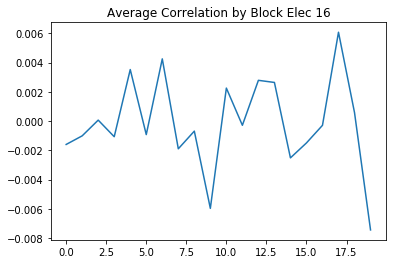

In [41]:
plt.plot(means)
plt.title('Average Correlation by Block Elec 16')
plt.show()

In [1]:
fig = plt.figure(figsize = (20,10)) 
plt.scatter(stims, cors, s = 10)
plt.xticks(rotation=90)
plt.ylabel('correlation coeffiecient')
plt.xlabel('stims')
plt.title('stim x average response correlation')
plt.show()



NameError: name 'plt' is not defined

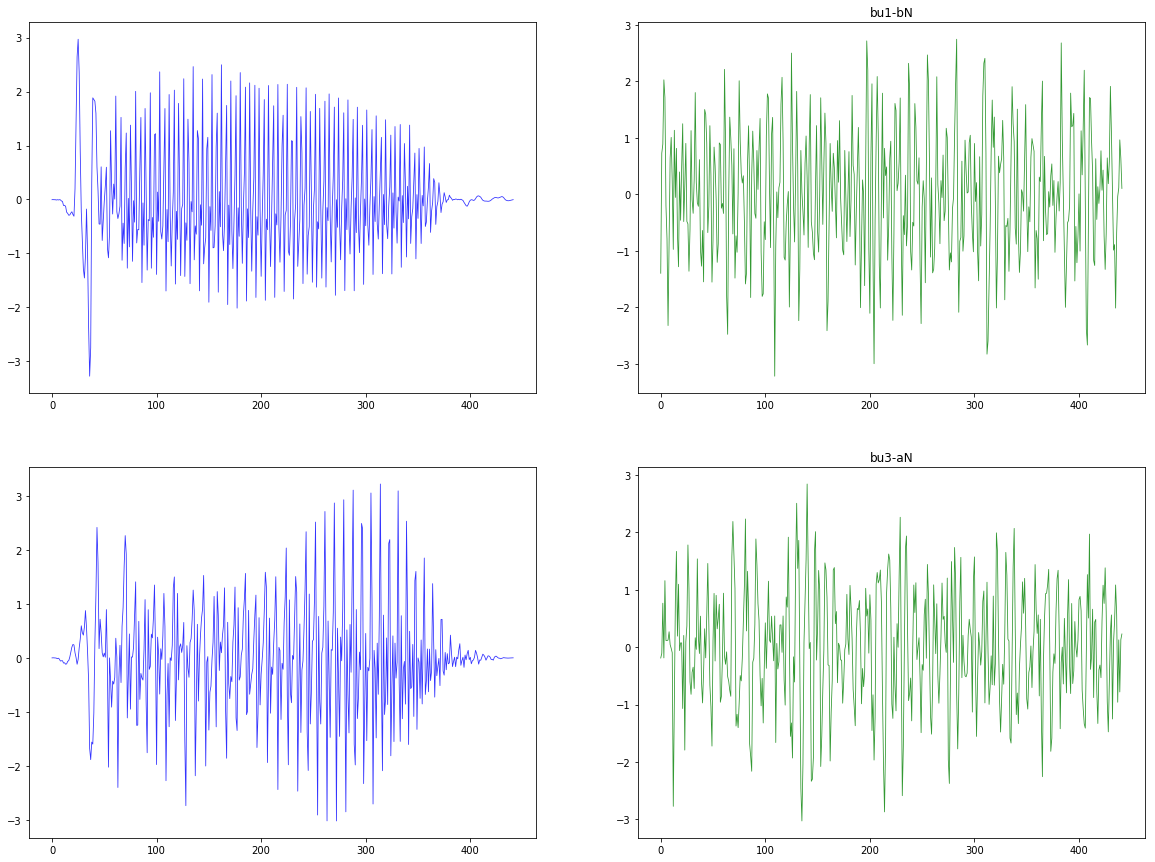

In [20]:
import sklearn
fig = plt.figure(figsize = (20,15)) 
s =['bu1-bN','bu3-aN']
# ,'lu3-aN','di2-aN'
i = 1
for sx in s:
    indx = np.where(behav['file'] == sx)[0]
    myhg1 = np.mean(hg_stim[indx, :, 119], axis = 0)
    myhg1 = sklearn.preprocessing.scale(myhg1)
    stim = sklearn.preprocessing.scale(dataStim[sx +'.wav'])
    plt.subplot(2,2,i)
    plt.plot(stim, linewidth=.8, c = 'b',alpha = .8)
    i+=1
    plt.subplot(2,2,i)
    plt.plot(myhg1[534:976], c = 'g',alpha = .8, linewidth=.8)
    plt.title(sx)
    i+=1
plt.show()


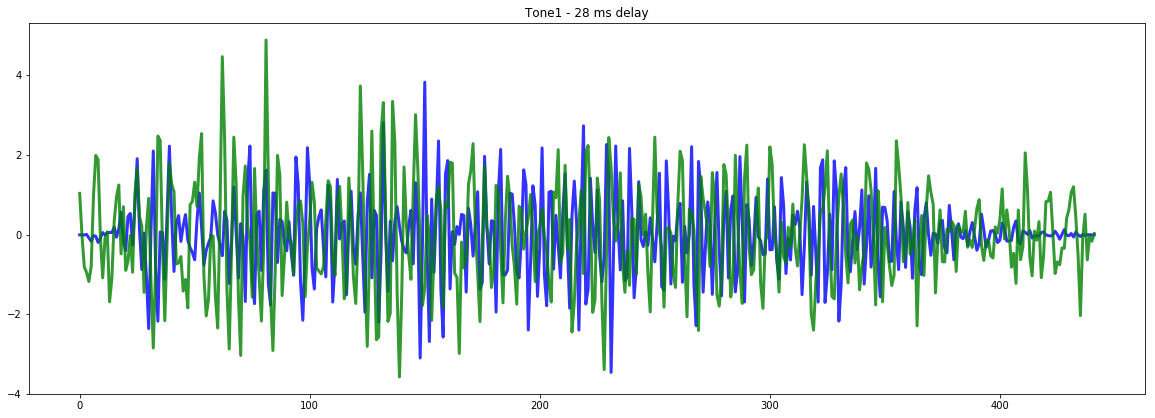

In [10]:
import sklearn
fig = plt.figure(figsize = (20,15)) 

i = 1
indx = np.where((behav['tone'] == 1) & (behav['speaker'] == 'b'))[0]
myhg1 = np.mean(hg_stim[indx, :, 119], axis = 0)
myhg1 = sklearn.preprocessing.scale(myhg1)
stim = sklearn.preprocessing.scale(mean1)
plt.subplot(2,1,1)
plt.plot(stim, linewidth=3, c = 'b',alpha = .8)
# plt.plot(myhg1[500:942], c = 'g',alpha = .8, linewidth=3)
plt.plot(myhg1[528:970], c = 'g',alpha = .8, linewidth=3)
plt.title('Tone1 - 28 ms delay')
plt.show()

In [53]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    #"full" mode returns results for every t where both a and v have some overlap.
    #"same" mode returns a result with the same length as the shortest vector (a or v).
    #"valid" mode returns results only when a and v completely overlap each other. The documentation for numpy.convolve gives more detail on the modes.
    return result[result.size/2:]

In [81]:
import pandas as pd
import itertools
import matplotlib as pyplot

Tones =['bu1-bN','bu3-aN','lu3-aN','di2-aN']
i = 1

dataFFR = pd.DataFrame()
dataLag = pd.DataFrame()
dataTest = pd.DataFrame()
data_all = pd.DataFrame()


for t in Tones:
    indx = np.where(behav['file'] == t)[0]
    myhg = np.mean(hg_stim[indx, :, 15], axis = 0)
    data_a = pd.DataFrame()
    start = -500 
    end = -420
    cor = np.zeros((72,81))
    d = np.zeros((72,81))
    dataLag = pd.DataFrame()
    dataLag[i] = np.zeros(76)

# #separate the data into times
    for x in range(0,72):
        index = np.where((time_axis <= end) & (time_axis >= start))[0]
        d[x,:] = myhg[index]
        end += 20
        start += 20
    
    maxs = []
    lag = []
    for bins in range(0,d.shape[0]):
        cor[bins,:] = autocorr(d[bins,:]) ## run autocorrelation
    for bins in range(1,cor.shape[0]): 
        maxx = max(cor[bins][2:15]) ##find the max
        maxs.append(maxx) #add max to a list
        lags = np.where(cor[bins] == maxx) ##finding the lag
        l = lags[0][0]
        lag.append(l)
        for time in range(2,15):
                if cor[bins,time] == maxx:
                    dataLag[i][time] = 1/time

    norms = []
    for m in maxs:
        high = max(maxs)
        low = min(maxs)
        n = 2*((m-low)/(high-low)) - 1
        norms.append(n)
    dataFFR[t] = norms
# #     dataFFR[file + '_'+ str(i)] = maxs
    print(lag)
#     bins = [item for sublist in lag for item in sublist]
#     lags = [1/x for x in bins]
#     dataFFR['bin_' + str(t)] = bins
    dataFFR['lag_' + str(t)] = lag
#     dataTest['bin_' + str(i)] = bins
#     dataTest['lag_' + str(i)] = lags
    

[13, 11, 11, 11, 11, 11, 11, 11, 11, 9, 9, 11, 11, 11, 9, 9, 14, 11, 11, 11, 8, 9, 9, 11, 10, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 12, 12, 10, 9, 8, 9, 12, 12, 12, 10, 10, 10, 9, 8, 8, 8, 13, 13, 11, 11, 11, 12, 12, 12, 12, 13, 9, 9, 7, 7, 14]
[13, 12, 12, 12, 10, 10, 10, 9, 10, 10, 11, 11, 10, 10, 13, 12, 12, 12, 12, 9, 9, 9, 11, 9, 14, 10, 10, 9, 9, 9, 9, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 10, 11, 12, 12, 13, 12, 12, 11, 11, 10, 10, 10, 10, 9, 8, 8, 8, 7, 7, 13, 7, 13, 7, 12, 11, 14, 9, 9, 9]
[11, 11, 11, 11, 11, 11, 12, 9, 13, 13, 12, 12, 12, 13, 7, 11, 10, 10, 9, 10, 10, 10, 10, 9, 9, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 9, 10, 9, 9, 9, 9, 9, 9, 8, 9, 7, 7, 9, 9, 9, 14, 14, 8, 13, 11, 11, 11, 10, 10, 12, 8, 8, 9, 9, 9, 9, 9, 13, 13, 12, 12]
[10, 12, 12, 11, 11, 11, 12, 12, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 8, 9, 9, 9, 9, 8, 8, 8, 8, 8, 8, 11, 11, 11, 10, 9, 9, 9, 9, 9, 10, 12, 12, 12, 11, 11, 11, 14, 14, 10, 10, 11, 11, 11, 11, 11, 11, 14, 13, 9, 9, 9,

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


[0, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 460, 480, 500, 520, 540, 560, 580, 600, 620, 640, 660, 680, 700, 720, 740, 760, 780, 800, 820, 840, 860, 880, 900, 920, 940, 960, 980, 1000, 1020, 1040, 1060, 1080, 1100, 1120, 1140, 1160, 1180, 1200, 1220, 1240, 1260, 1280, 1300, 1320, 1340, 1360, 1380, 1400]


/Users/alia/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


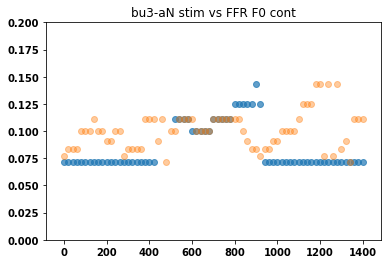

In [130]:
li = list(range(71))
lx = [o*20 for o in li]
print(lx)
plt.scatter(lx,dataLag['bu3-aN.wav'][0:71], alpha = .7)
plt.scatter(lx,(1/dataFFR['lag_bu3-aN']), alpha = .4)
plt.ylim(0,.2)
plt.title('bu3-aN stim vs FFR F0 cont')
plt.show()


In [105]:
## get list of tones
tones = np.unique(behav['file'])
tones = tones.tolist()

In [106]:
##read wav file 
## data2 = autocorr dataframe

'''this reads each wav file, zero pads it to match the FFR, runs autocorr on all stimuli and then 
    normalizing from -1 to 1'''
import scipy.io
import os

'''autocorr the stimulation wav files t = tone, p = b or h, male or female'''
dirs = os.listdir('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/')
tone = []
files = []
lists = []
tones = []
# start = 0
# end = 50
positive = np.zeros((558,))
negative = np.zeros((500,))

data2 = pd.DataFrame()
dataLag = pd.DataFrame()
# dataLag['1/lag'] = np.zeros(76)
# dataLag['max'] = np.zeros(76)

# print(d.shape)
for i in dirs:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    a= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i, sr = 1000) ##changes the sr to 1000
    y = np.append(y,positive)
    y = np.insert(y,0,negative)
    start = 0 
    end = 80
    cor = np.zeros((72,80))
    d = np.zeros((72,80))
    dataLag[i] = np.zeros(76)
    lag = []
    #separate the data into times
    for x in range(70):
        index = list(range(start,end))
        d[x,:] = y[index]        
        end += 20
        start += 20 

    # # do autocorr on all bins 
    for bins in range(0,d.shape[0]): 
        cor[bins,:] = autocorr(d[bins,:])
    data2[i] = np.zeros(71)
    maxs = []
    lags1 = []
    for bins in range(1,cor.shape[0]): 
        maxx = max(cor[bins,:])
        lags = np.where(cor[bins] == maxx)[0]
#         lags = np.array(lags).tolist()
        maxs.append(maxx)
#     dataLag[i] = 1/lags

    for j in range(0,cor.shape[0]):
        nozero = cor[j,2:15]
        maxes = max(nozero)
        for time in range(2,15):
            if cor[j,time] == maxes:
                dataLag[i][j] = 1/time
#                 dataLag['max_' + str(i)][j] = cor[j,time]
    norms = []
    for m in maxs:
        high = max(maxs)
        low = min(maxs)
        n = 2*((m-low)/(high-low)) - 1
        norms.append(n)
    data2[i] = norms
#     data2[i] = maxs
dataBin = pd.DataFrame()
a = [x for x in range(len(dataLag))]
dataBin['bin'] = a 

/Users/alia/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  


/Users/alia/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


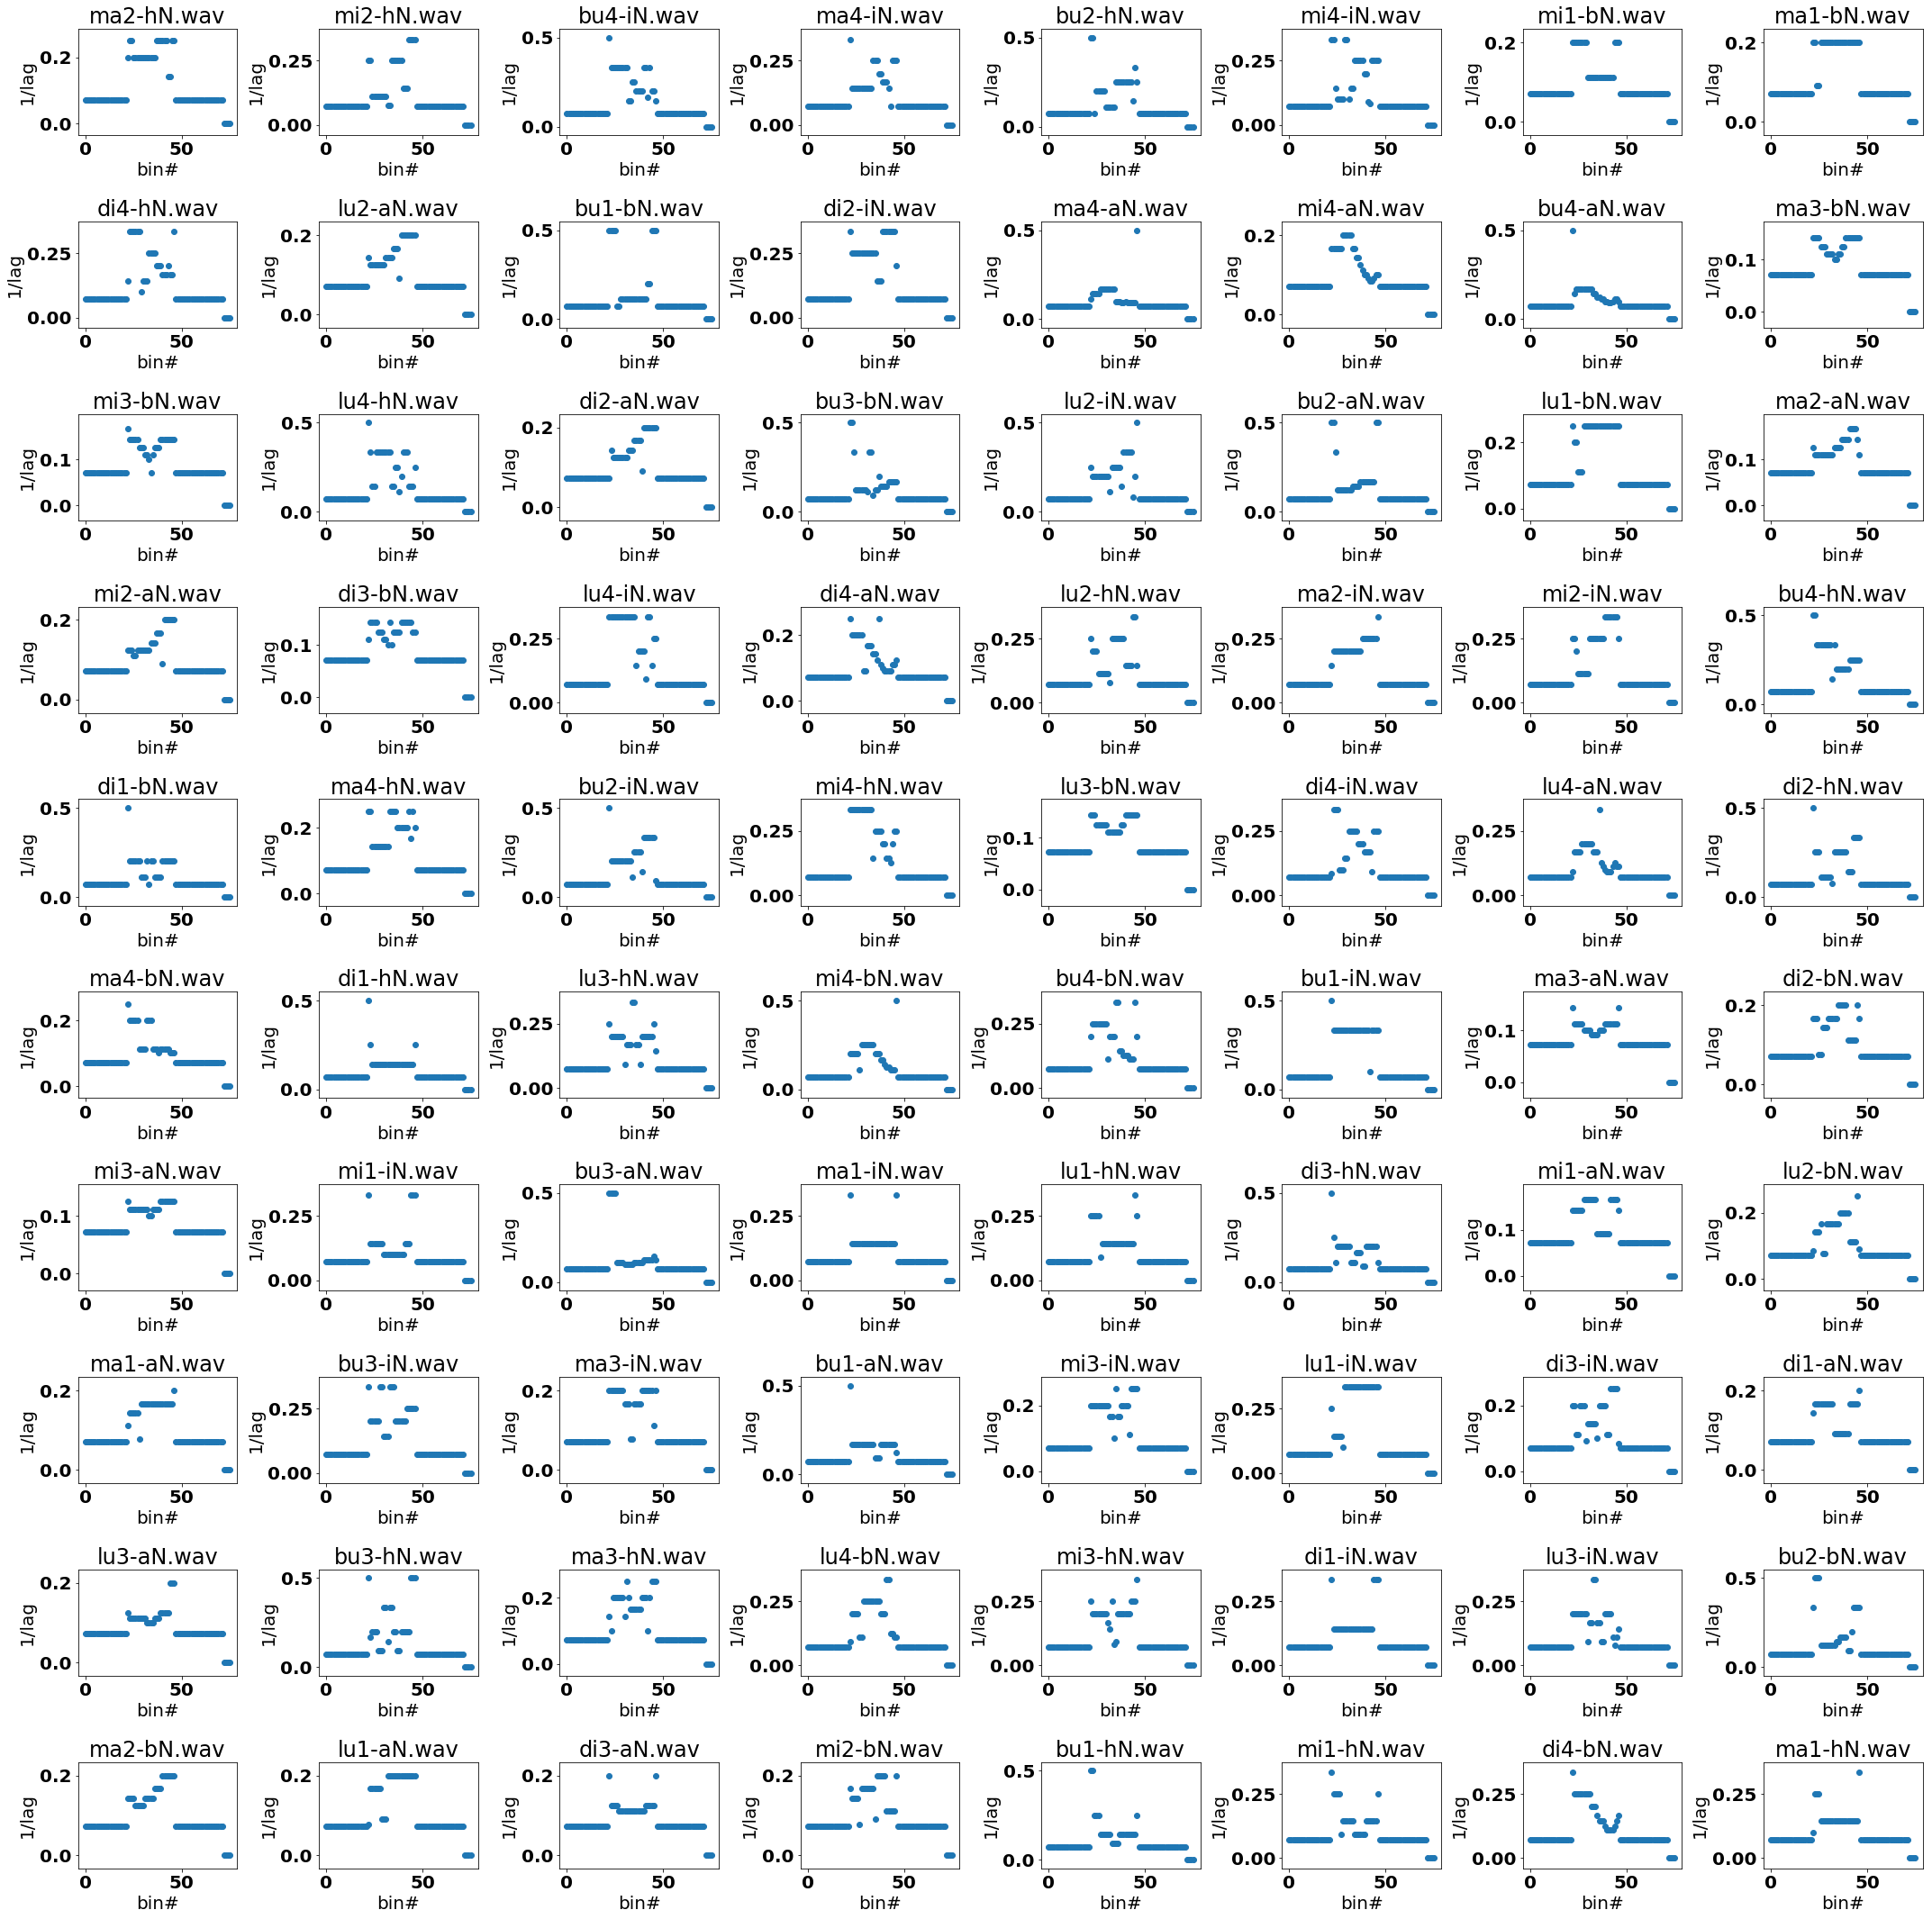

In [108]:
p = 1
fig = plt.figure(figsize = (30,30))
for i in dataLag:
    plt.subplot(10,8,p)
    plt.scatter(dataBin['bin'],dataLag[i])
    plt.title(i)
    plt.ylabel('1/lag')
    plt.xlabel('bin#')
    p += 1 
plt.tight_layout()
plt.show()

## Plot

In [122]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 10}

matplotlib.rc('font', **font)

/Users/alia/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


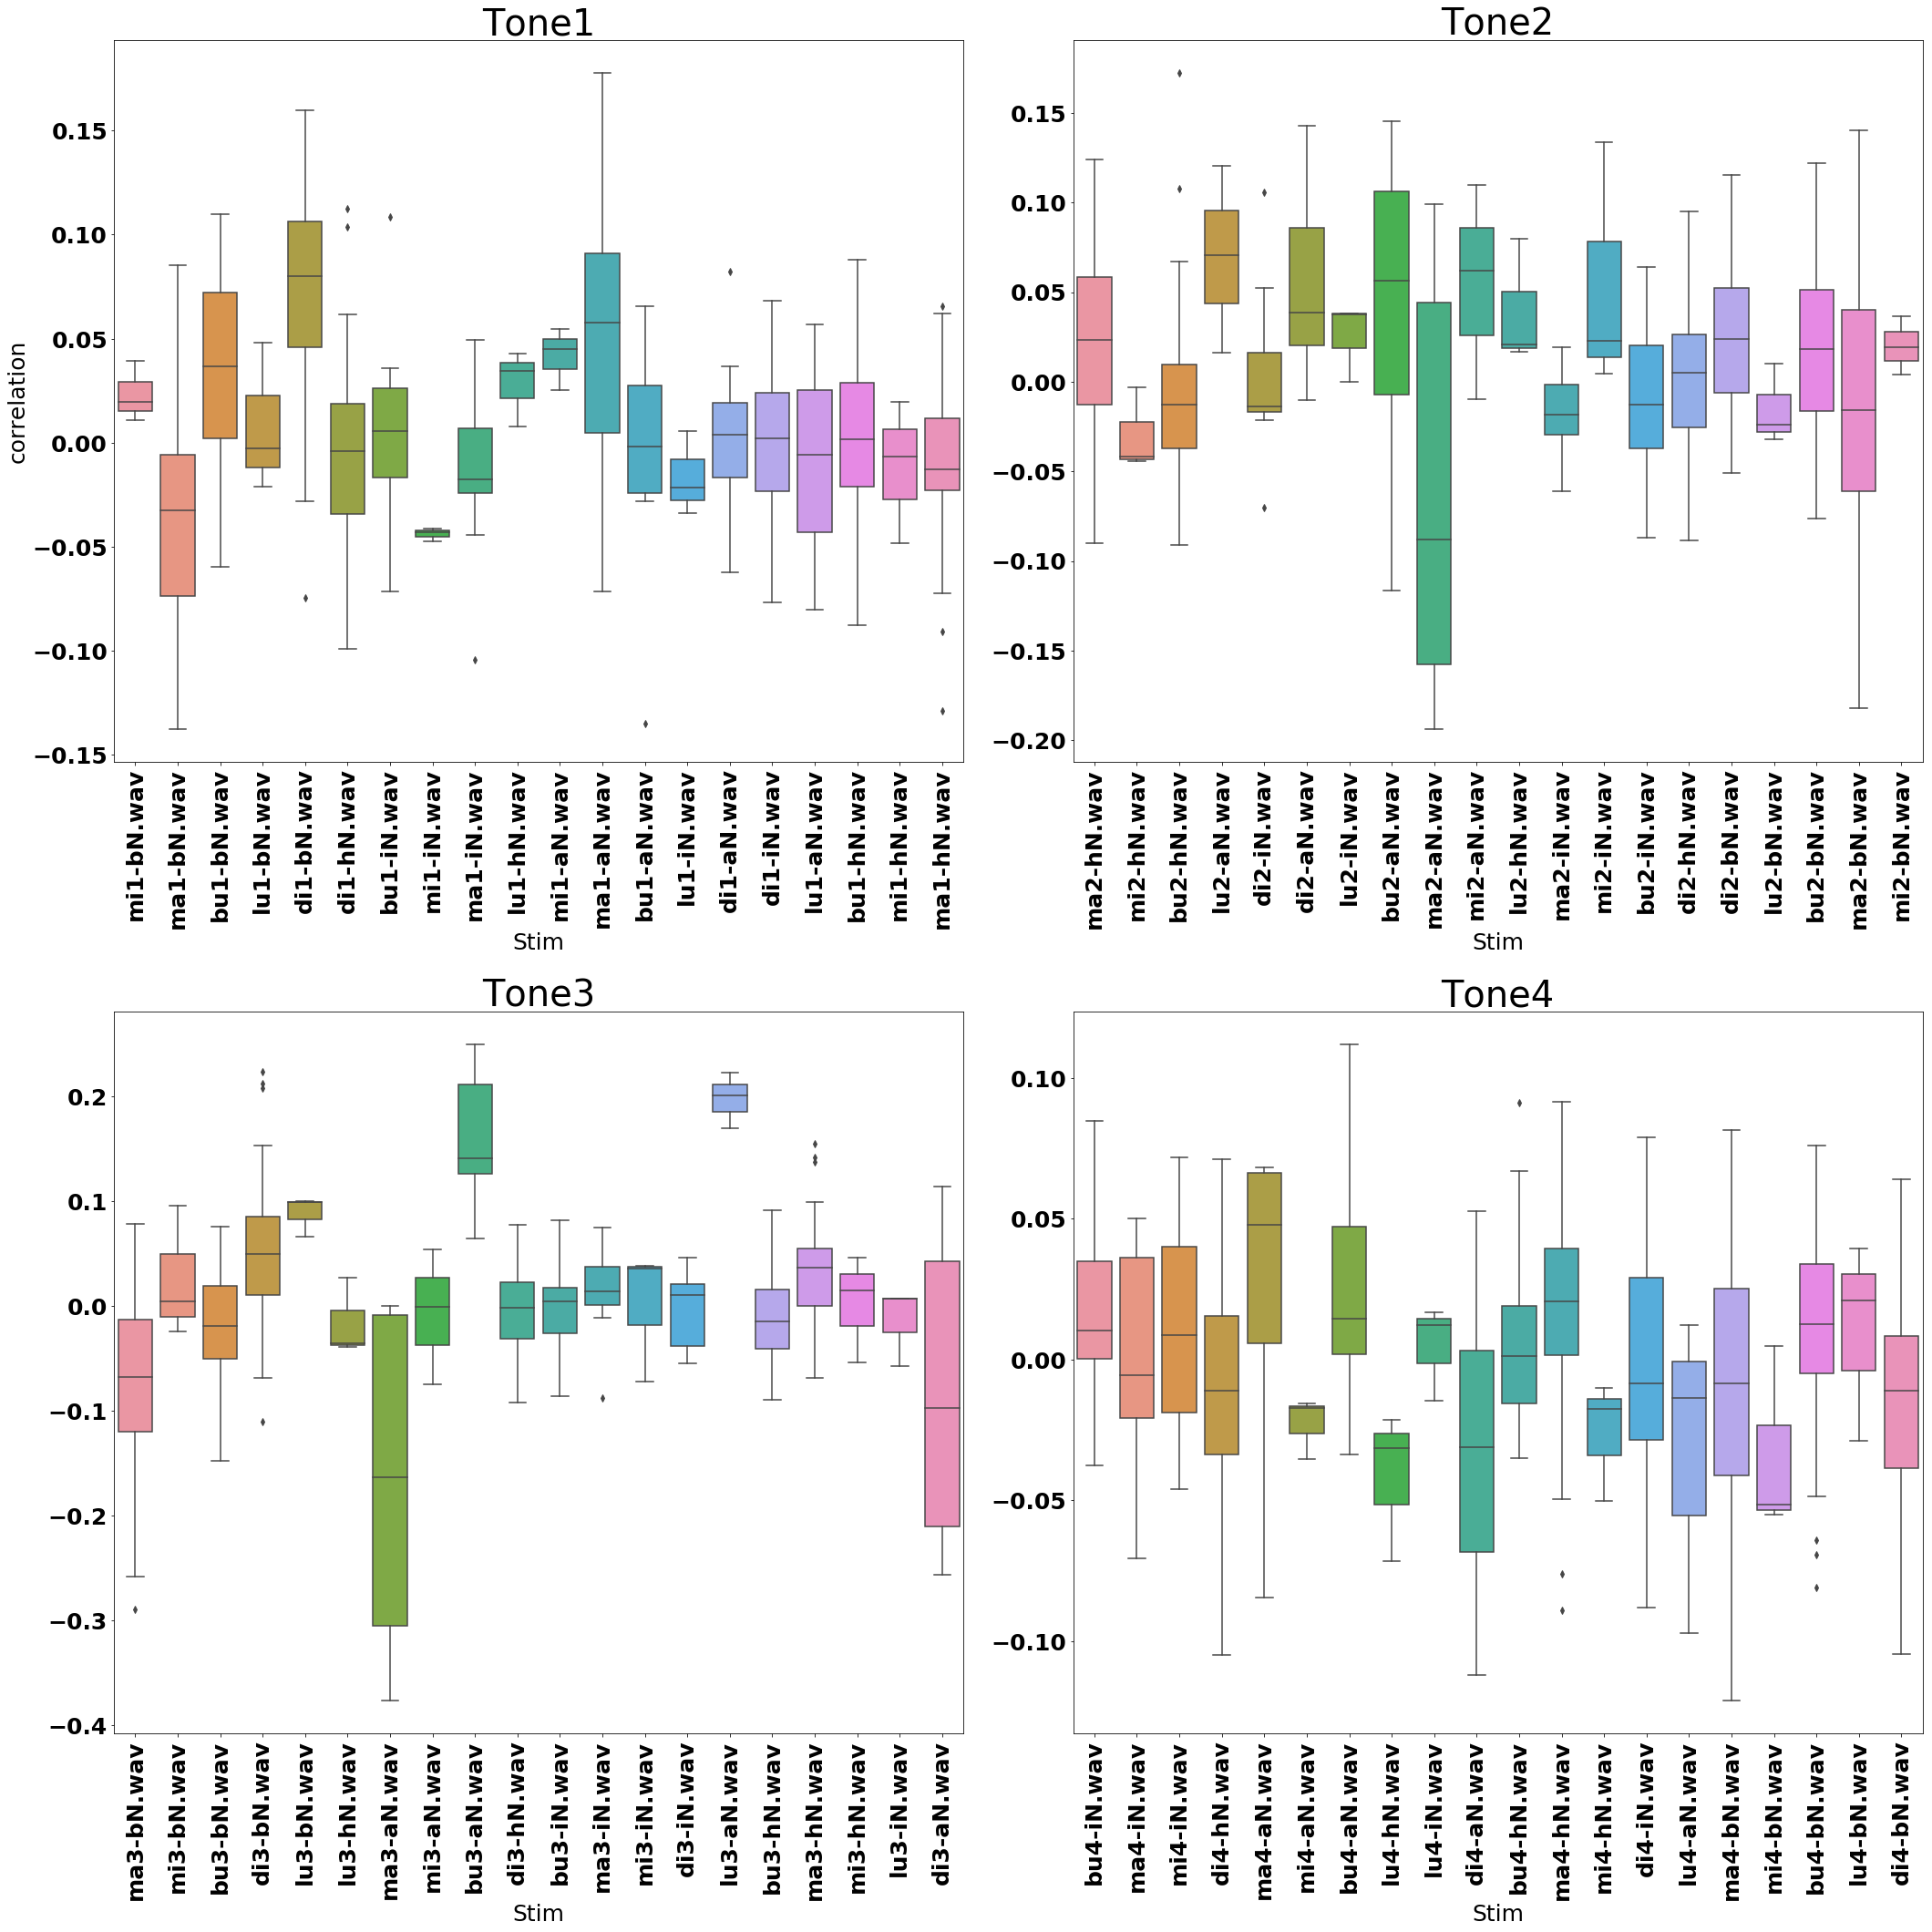

In [30]:
fig = plt.figure(figsize = (30,30)) 
plt.subplot(2,2,1)
sns.boxplot(data = correlations1)
plt.xlabel('Stim', fontsize = 25)
plt.ylabel('correlation',fontsize = 25)
plt.xticks(rotation=90)
plt.title('Tone1', fontsize = 40)


plt.subplot(2,2,2)
sns.boxplot(data = correlations2)
plt.title('Tone2', fontsize = 40)
plt.xlabel('Stim', fontsize = 25)
plt.xticks(rotation=90)


plt.subplot(2,2,3)
sns.boxplot(data = correlations3)
plt.title('Tone3', fontsize = 40)
plt.xlabel('Stim', fontsize = 25)
plt.xticks(rotation=90)


plt.subplot(2,2,4)
sns.boxplot(data = correlations4)
plt.title('Tone4', fontsize = 40)
plt.xlabel('Stim', fontsize = 25)
plt.xticks(rotation=90)

# plt.suptitle('Male elec 16', fontsize = 50)
plt.tight_layout()
plt.show()

## Check FFR visually 

In [23]:
test = np.unique(behav['file'])
print(test)

['bu1-aN' 'bu1-bN' 'bu1-hN' 'bu1-iN' 'bu2-aN' 'bu2-bN' 'bu2-hN' 'bu2-iN'
 'bu3-aN' 'bu3-bN' 'bu3-hN' 'bu3-iN' 'bu4-aN' 'bu4-bN' 'bu4-hN' 'bu4-iN'
 'di1-aN' 'di1-bN' 'di1-hN' 'di1-iN' 'di2-aN' 'di2-bN' 'di2-hN' 'di2-iN'
 'di3-aN' 'di3-bN' 'di3-hN' 'di3-iN' 'di4-aN' 'di4-bN' 'di4-hN' 'di4-iN'
 'lu1-aN' 'lu1-bN' 'lu1-hN' 'lu1-iN' 'lu2-aN' 'lu2-bN' 'lu2-hN' 'lu2-iN'
 'lu3-aN' 'lu3-bN' 'lu3-hN' 'lu3-iN' 'lu4-aN' 'lu4-bN' 'lu4-hN' 'lu4-iN'
 'ma1-aN' 'ma1-bN' 'ma1-hN' 'ma1-iN' 'ma2-aN' 'ma2-bN' 'ma2-hN' 'ma2-iN'
 'ma3-aN' 'ma3-bN' 'ma3-hN' 'ma3-iN' 'ma4-aN' 'ma4-bN' 'ma4-hN' 'ma4-iN'
 'mi1-aN' 'mi1-bN' 'mi1-hN' 'mi1-iN' 'mi2-aN' 'mi2-bN' 'mi2-hN' 'mi2-iN'
 'mi3-aN' 'mi3-bN' 'mi3-hN' 'mi3-iN' 'mi4-aN' 'mi4-bN' 'mi4-hN' 'mi4-iN']


/Users/alia/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


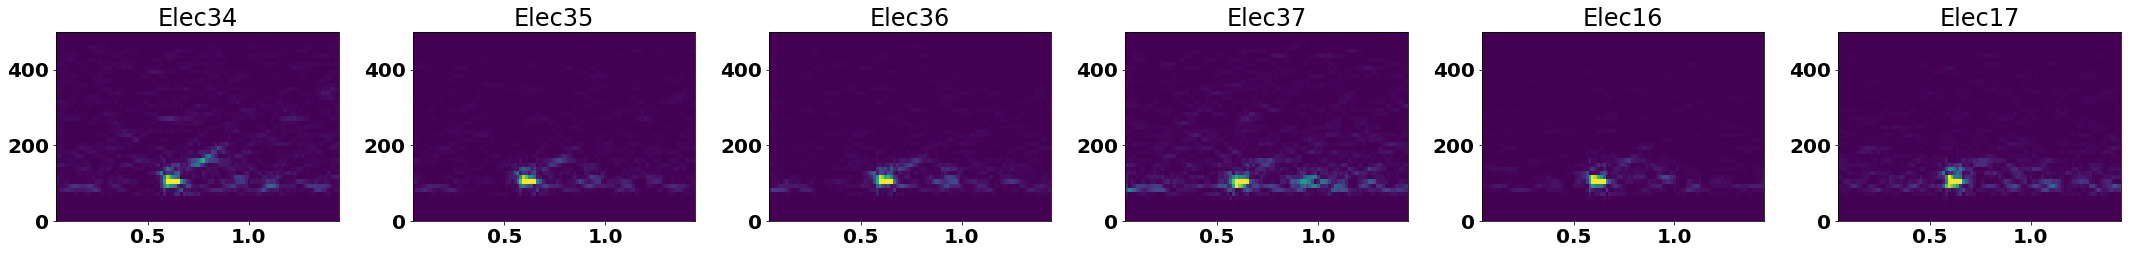

In [21]:
elec = [34,35,36,37,16,17]
x = 1
FFR = np.where((behav['block'] < 22)& (behav['file'] == 'ma2-bN'))[0]
fig = plt.figure(figsize = (30,20)) 
for e in elec:
    plt.subplot(6,6,x)
    myhg = np.mean(hg_stim[FFR, :, e], axis = 0)
    f,t, Sxx = signal.spectrogram(myhg, 1000, noverlap = 76, nperseg =90)
    plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
    plt.title('Elec' + str(e))
    x+=1
# plt.suptitle('ma2-bN')
plt.tight_layout()
plt.show()

In [17]:
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}

matplotlib.rc('font', **font)

/Users/alia/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


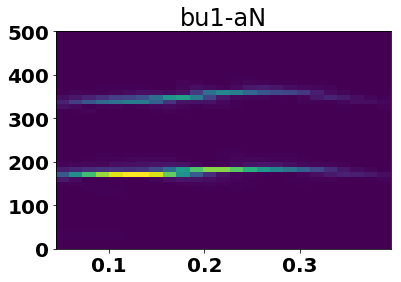

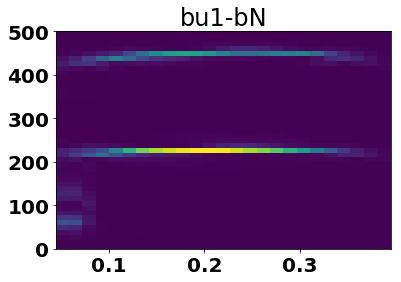

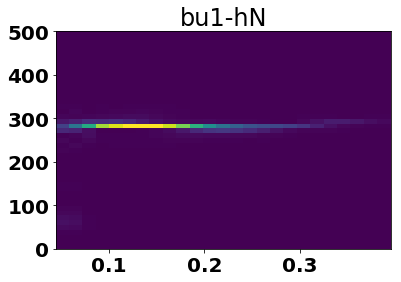

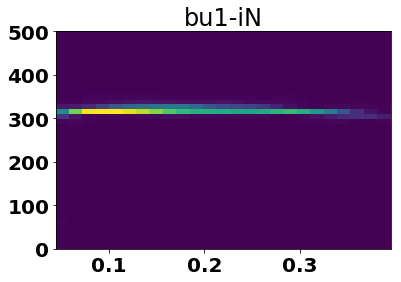

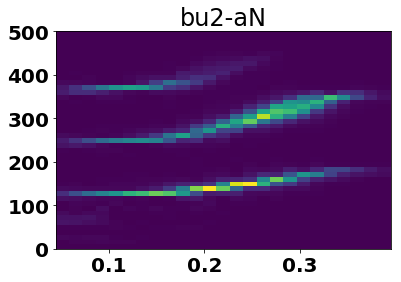

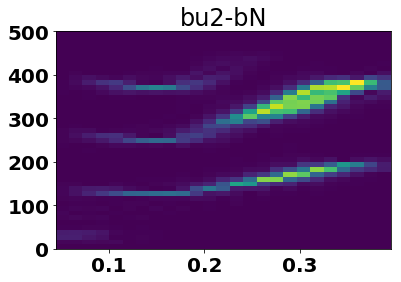

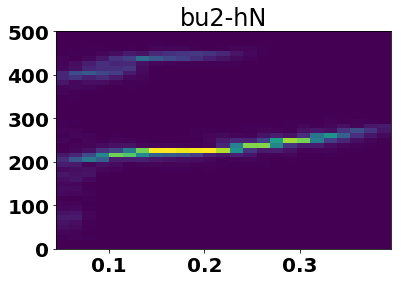

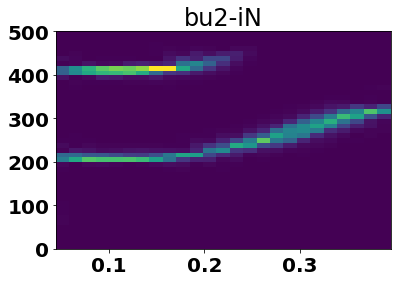

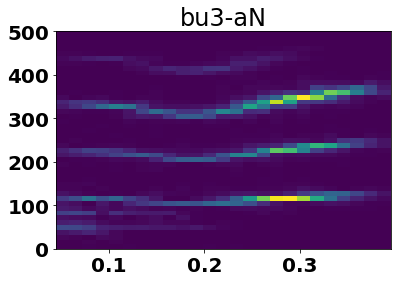

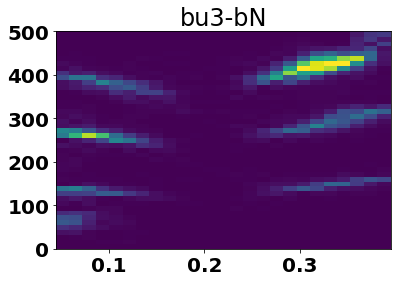

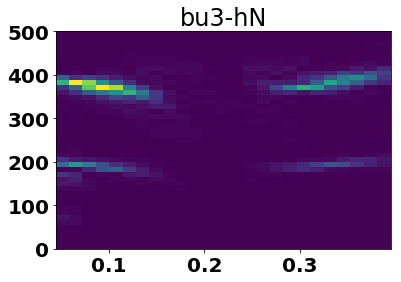

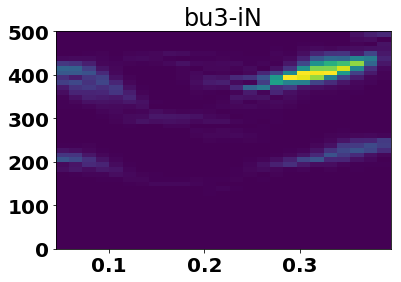

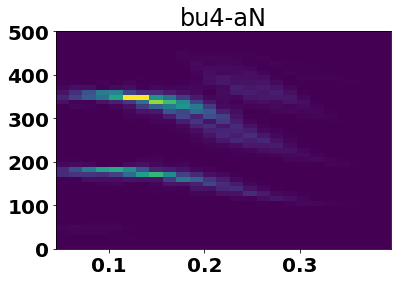

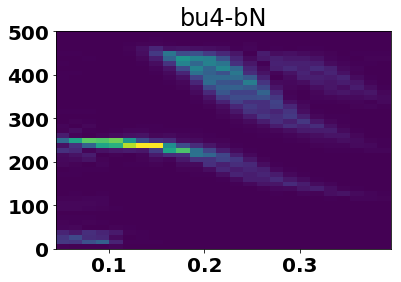

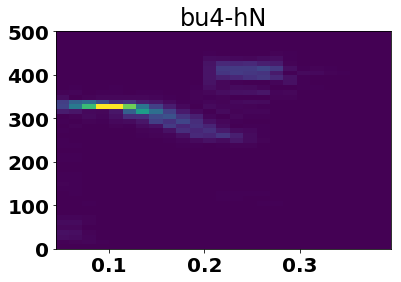

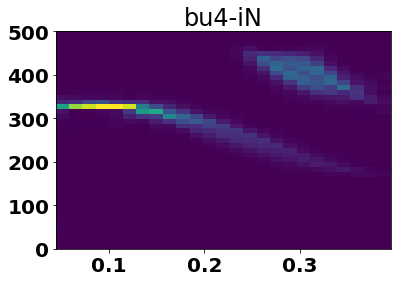

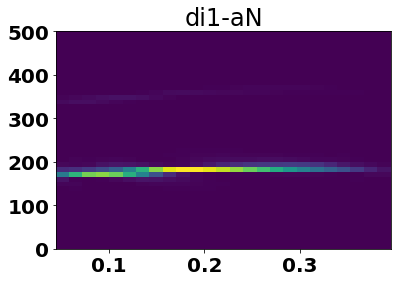

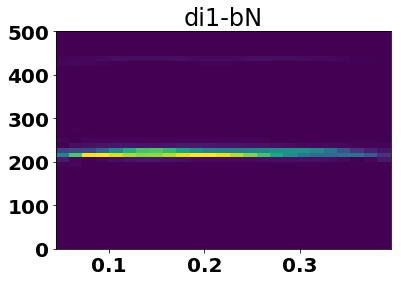

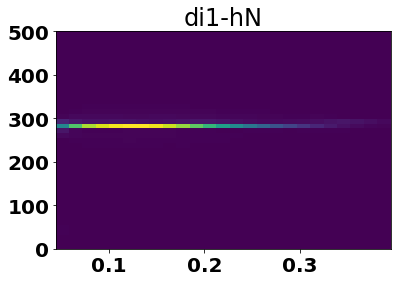

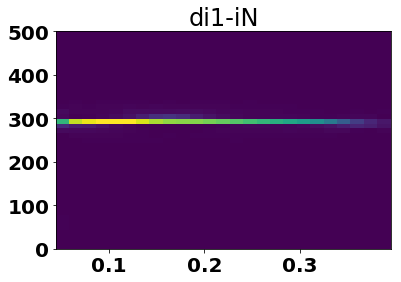

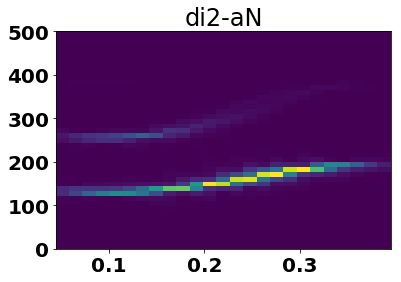

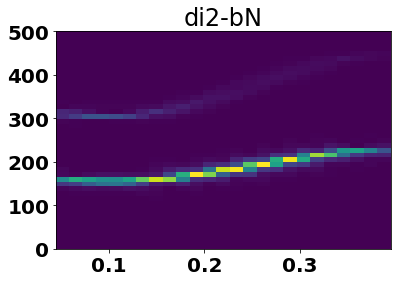

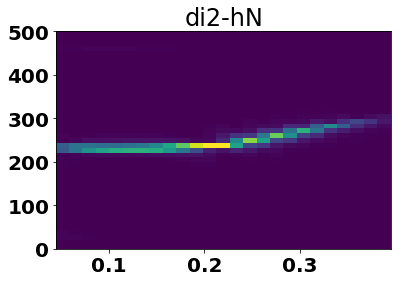

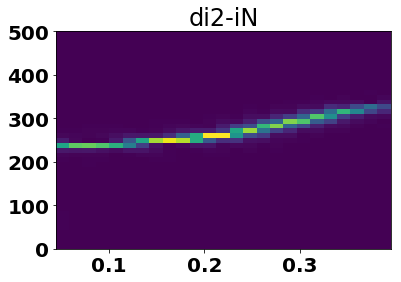

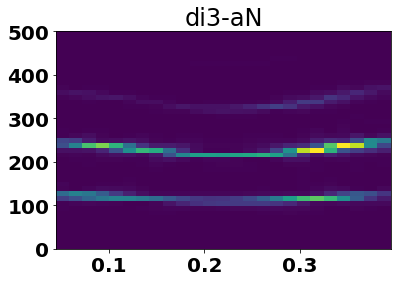

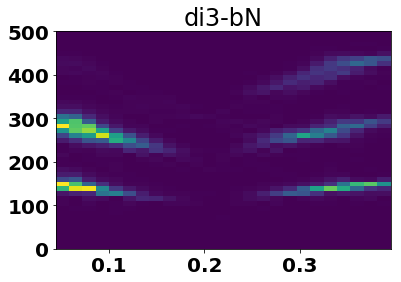

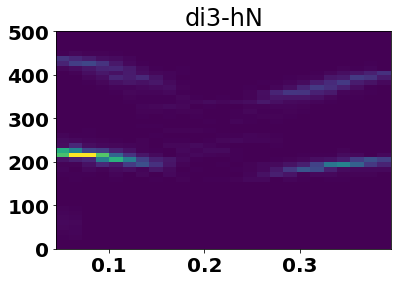

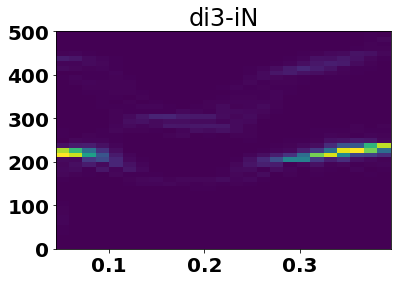

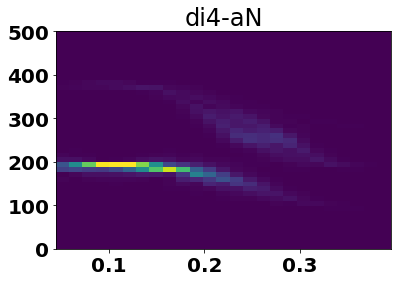

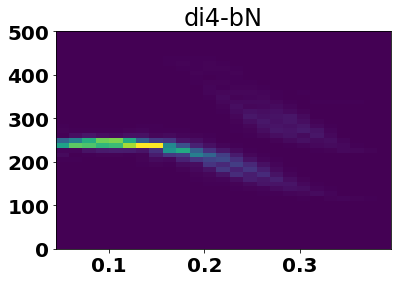

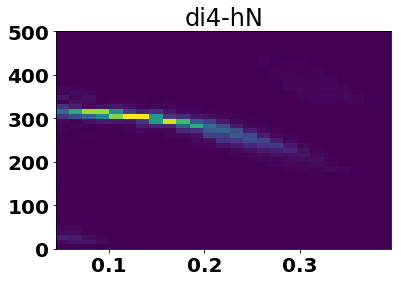

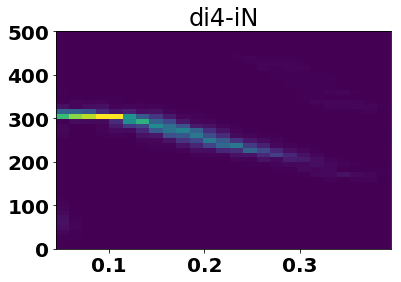

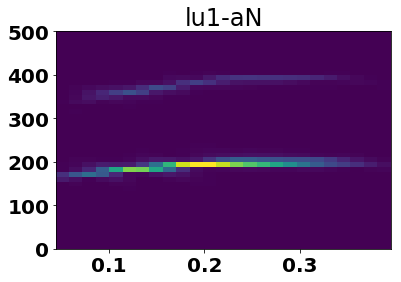

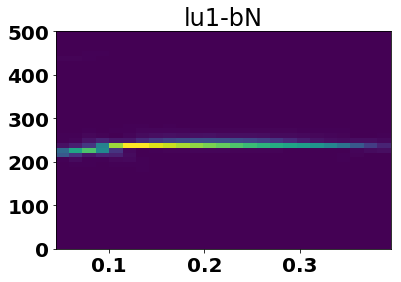

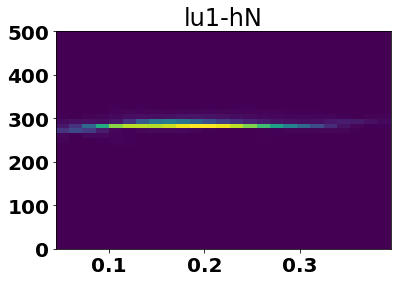

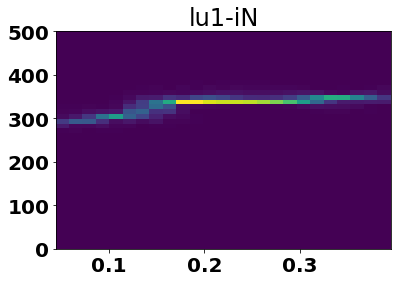

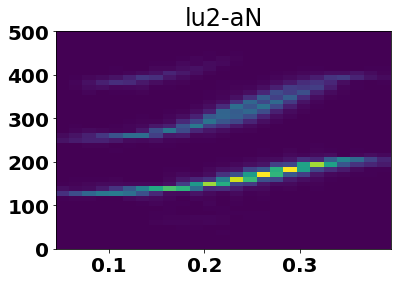

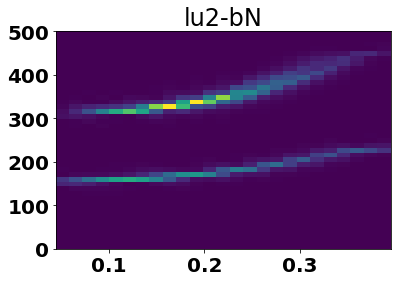

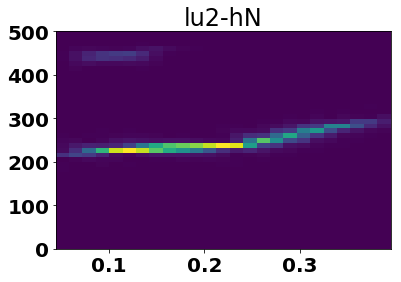

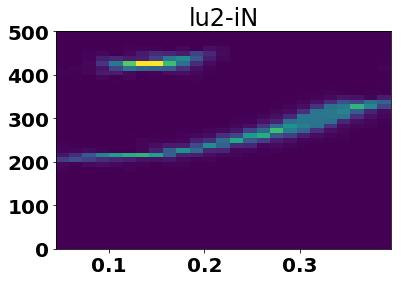

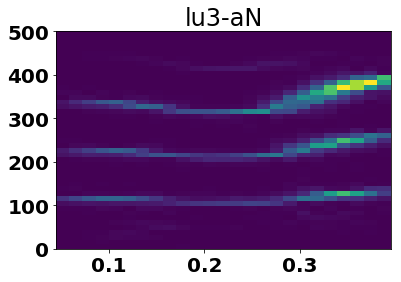

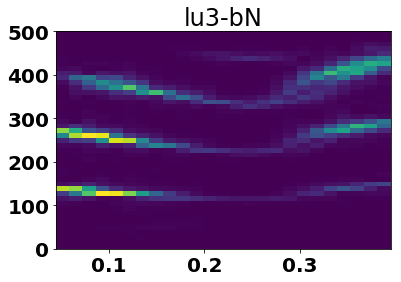

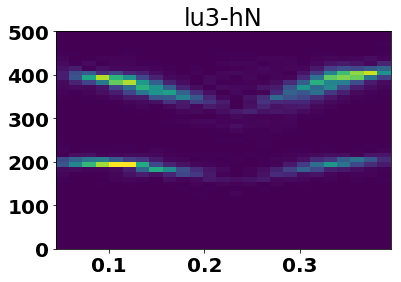

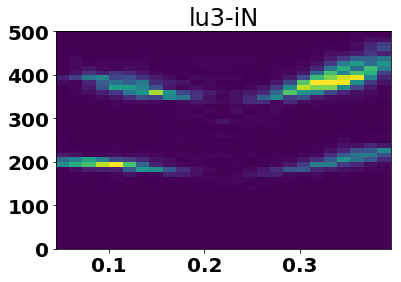

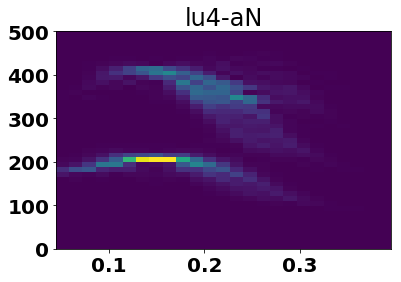

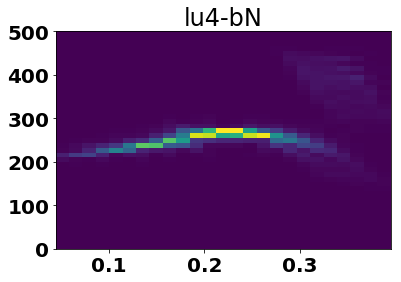

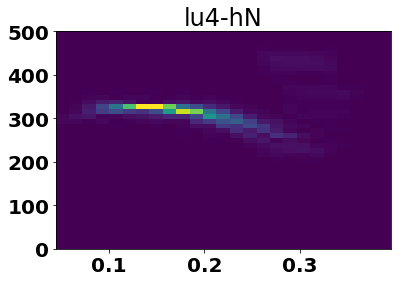

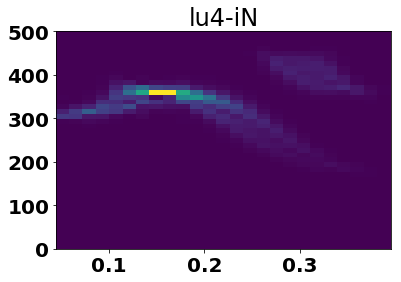

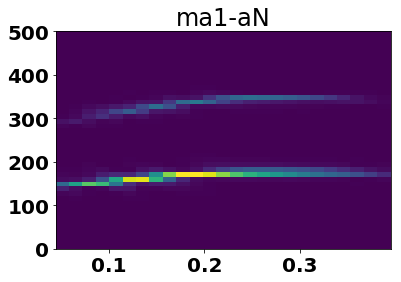

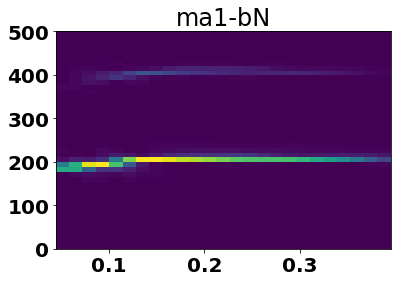

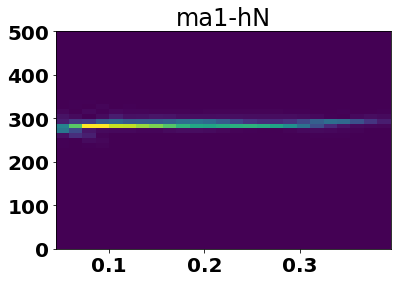

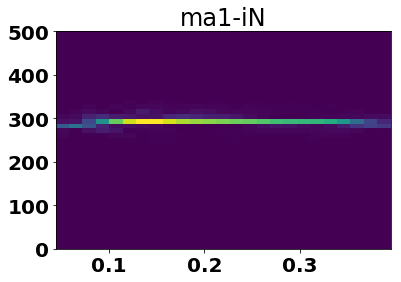

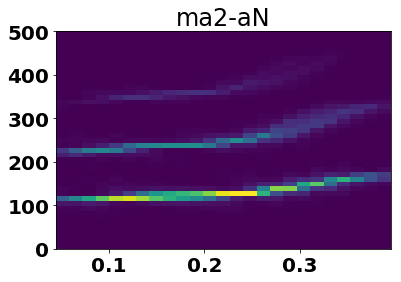

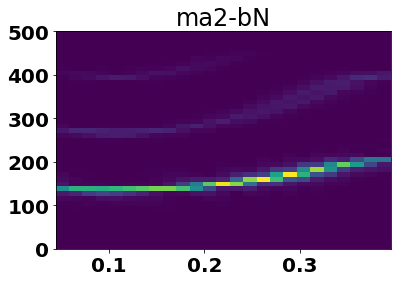

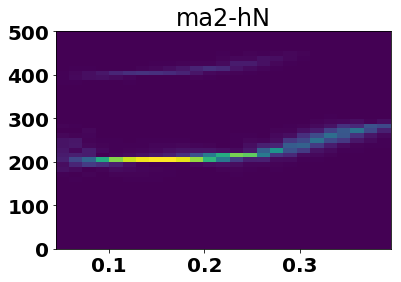

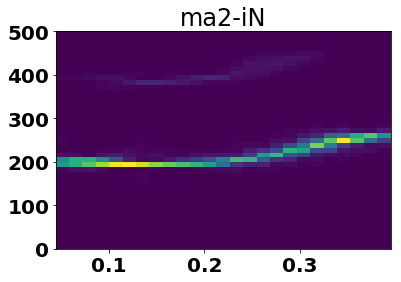

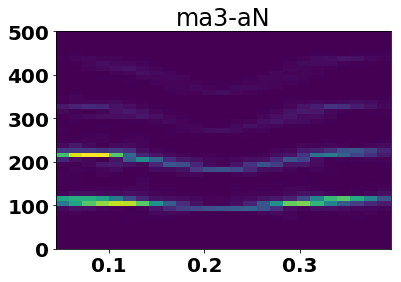

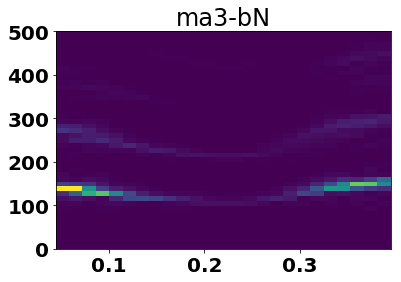

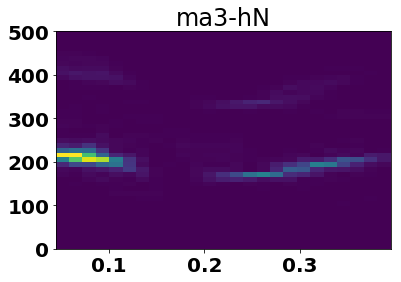

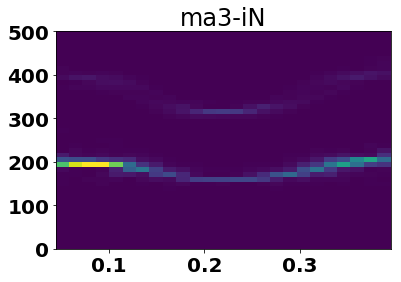

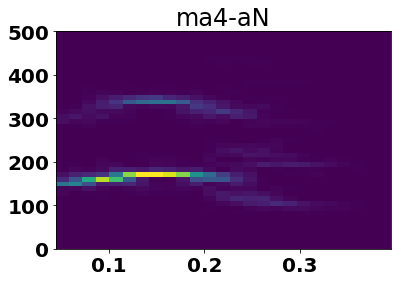

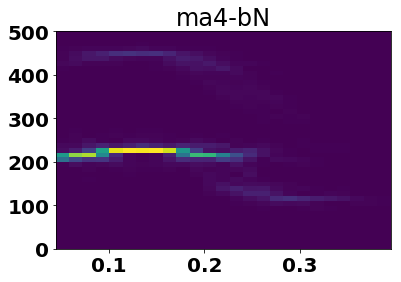

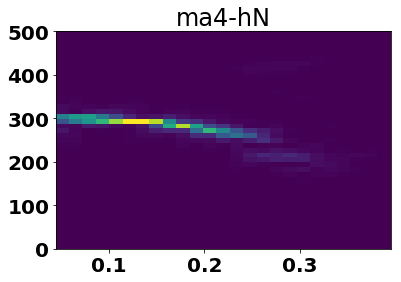

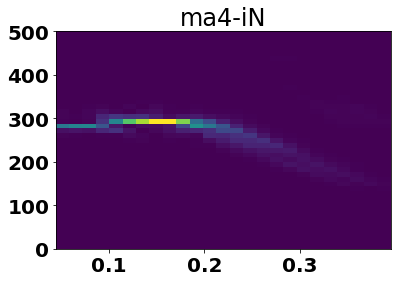

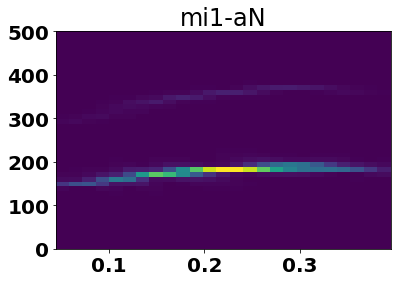

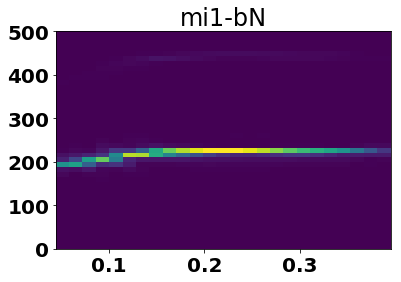

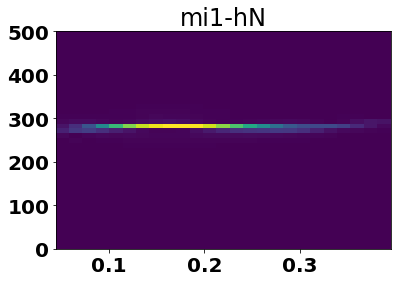

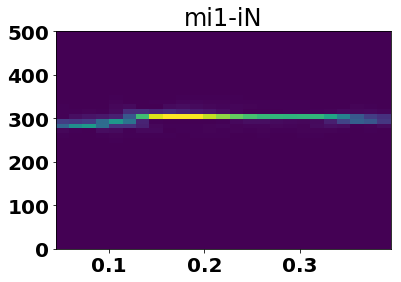

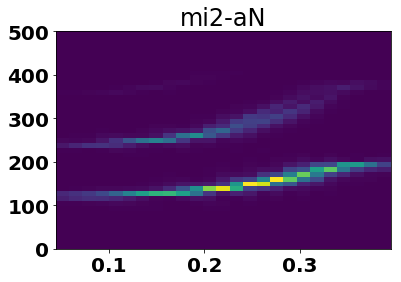

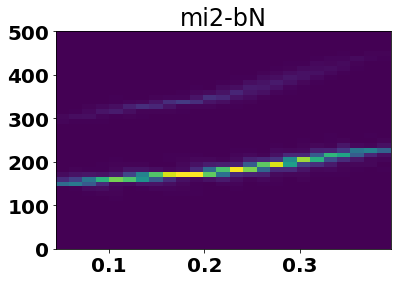

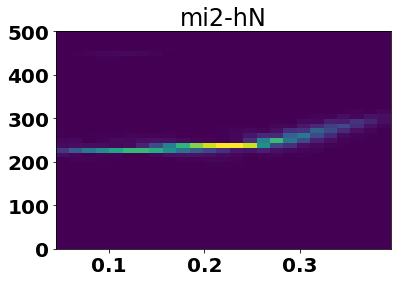

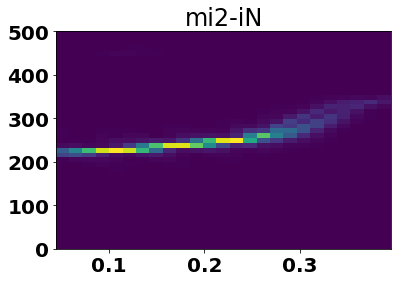

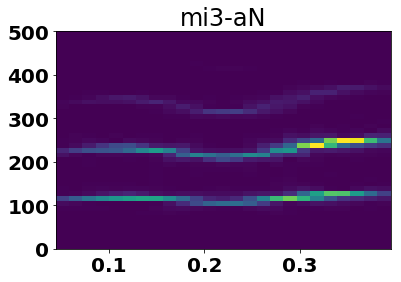

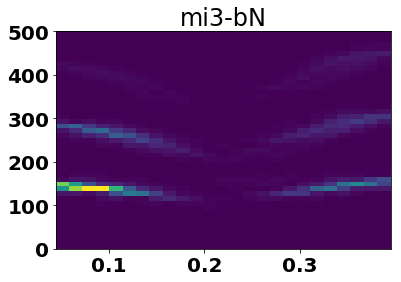

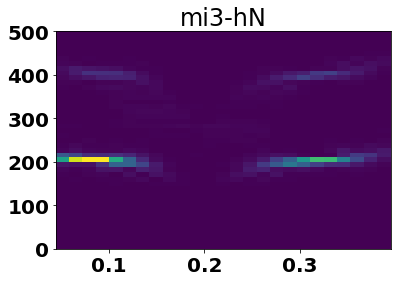

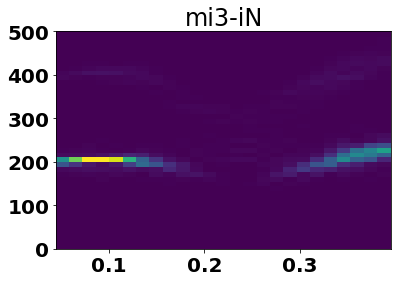

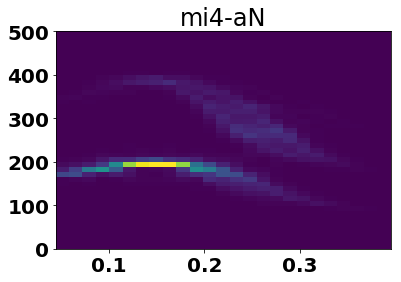

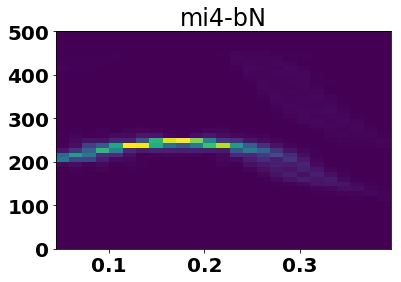

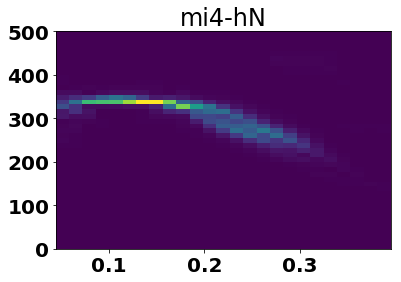

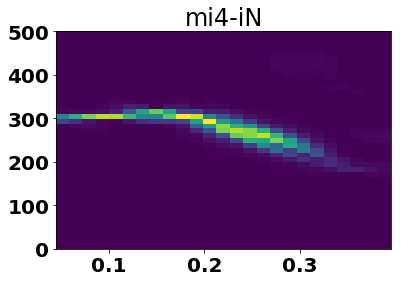

In [24]:
# f,t, Sxx = signal.spectrogram(myhg, fs, noverlap = 76, nperseg =90)
# plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
for i in test:
    y, sr= librosa.load('/Users/alia/Documents/dura/userdata/ashafi/alia_temp_1/stimwav/' + i + '.wav', sr = 1000)
    f,t, Sxx = signal.spectrogram(y, 1000, noverlap = 76, nperseg =90)
    plt.pcolormesh(t,f,Sxx, vmax = np.percentile(Sxx.flatten(), 99.9))
    plt.title(i)
    plt.show()